In [2]:
# import core libraries for working with images, data, and visualization
import os
from PIL import Image  # for loading images
import matplotlib.pyplot as plt  # for visualization
import pandas as pd  # for tabular data
import numpy as np  # for numerical operations

In [3]:
# set up paths
DATA_DIR = "../data/food-101"
IMAGES_DIR = os.path.join(DATA_DIR, "images")
META_DIR = os.path.join(DATA_DIR, "meta")

# check first few class (food) names
food_classes = sorted(os.listdir(IMAGES_DIR))
print(f"Number of classes: {len(food_classes)}")
print(f"Example classes: {food_classes[:5]}")

Number of classes: 102
Example classes: ['.DS_Store', 'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio']


In [4]:
with open(os.path.join(META_DIR, "train.txt"), "r") as f:
    train_files = f.read().splitlines()
with open(os.path.join(META_DIR, "test.txt"), "r") as f:
    test_files = f.read().splitlines()

Randomly selected class: ceviche


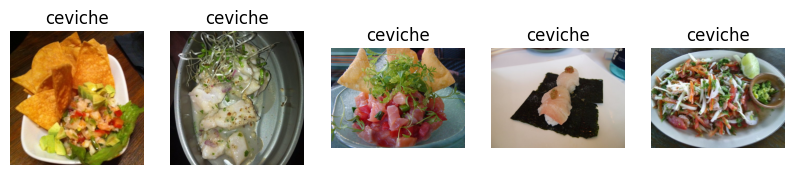

In [5]:
import random

# pick a random class (food type)
random_class = random.choice(food_classes)
print(f"Randomly selected class: {random_class}")

# get all image files for this class
image_files = os.listdir(os.path.join(IMAGES_DIR, random_class))

# show a few images from this class
plt.figure(figsize=(10,4))
for i in range(5):
    img_path = os.path.join(IMAGES_DIR, random_class, image_files[i])
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(random_class)
plt.show()

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [7]:
# define image transformations for preprocessing
img_size = 224  # standard for pretrained models
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # resize to 224x224
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet mean/std
                         std=[0.229, 0.224, 0.225])
])

In [8]:
class Food101Dataset(Dataset):
    def __init__(self, file_list, img_dir, class_names, transform=None):
        self.file_list = file_list  # list of "class/image" strings
        self.img_dir = img_dir
        self.class_names = class_names
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file = self.file_list[idx]
        class_name, img_name = file.split("/")
        img_path = os.path.join(self.img_dir, class_name, img_name + ".jpg")
        image = Image.open(img_path).convert('RGB')
        label = self.class_names.index(class_name)
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
batch_size = 32

# create datasets
train_dataset = Food101Dataset(train_files, IMAGES_DIR, food_classes, transform)
test_dataset = Food101Dataset(test_files, IMAGES_DIR, food_classes, transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


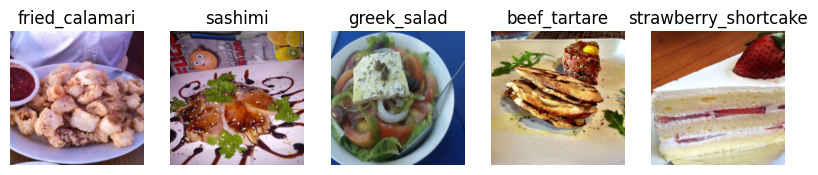

In [10]:
# fetch one batch and show shapes
images, labels = next(iter(train_loader))
print(f"Batch images shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")

# display a few sample images from the batch
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

plt.figure(figsize=(10,4))
for i in range(5):
    img = inv_normalize(images[i]).permute(1,2,0).numpy()  # undo normalization and convert to HWC
    img = np.clip(img, 0, 1)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(food_classes[labels[i]])
plt.show()

In [11]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [12]:
# load ResNet18 pretrained on ImageNet
model = models.resnet18(pretrained=True)

# replace final layer for 101 food classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(food_classes))  # 101 classes

# move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/Users/tafy/Desktop/P2/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tafy/Desktop/P2/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i == 2:  # Only test on first 3 batches (for speed)
            break

print(f"Test accuracy (sampled): {100 * correct / total:.2f}%")

Test accuracy (sampled): 0.00%


In [19]:
import pandas as pd

# Load the nutrition CSV just once
nutrition_df = pd.read_csv("../data/nutrition_lookup.csv")

def lookup_nutrition(food_class):
    """
    Return nutrition info dict for a given food class name.
    If not found, returns 'unknown' values.
    """
    row = nutrition_df[nutrition_df["food"] == food_class]
    if len(row) > 0:
        return {
            "calories_kcal": int(row.iloc[0]["calories_kcal"]),
            "protein_g": int(row.iloc[0]["protein_g"]),
            "carbs_g": int(row.iloc[0]["carbs_g"]),
            "fat_g": int(row.iloc[0]["fat_g"])
        }
    else:
        return {
            "calories_kcal": "unknown",
            "protein_g": "unknown",
            "carbs_g": "unknown",
            "fat_g": "unknown"
        }

In [20]:
test_class = "pizza"
nutrition_info = lookup_nutrition(test_class)
print(f"Nutrition for {test_class}: {nutrition_info}")

Nutrition for pizza: {'calories_kcal': 266, 'protein_g': 11, 'carbs_g': 33, 'fat_g': 10}


In [21]:
torch.save(model.state_dict(), "model.pth")